## Example of Weather Forecast with Lasso Model, Validation Included

#### Import Libraries

In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data manipulation and analysis; includes useful functions for date arithmetic
import xarray as xr               # library for handling multi-dimensional arrays, especially tailored for weather and climate data

from os import path               # module to interact with the operating system, includes functions for path manipulations
from warnings import simplefilter # module to control the display of warnings

from confer_wp3.dataloading import load_raw_data, save_anomalies, save_eofs_pcs, save_model_results
                                  # custom module to handle data loading and saving operations for the project
from confer_wp3.lasso_forecast import calculate_anomalies, compute_eofs_pcs, quantile_mapping, get_all_indices, get_ml_results, calculate_tercile_probability_forecasts
                                  # custom module containing functions for anomaly calculation, quantile mapping, EOF and PC computation, index retrieval, machine learning model results, and forecast probability calculations
from confer_wp3.plotting import plot_fields_simple, plot_combined_terciles
                                  # custom module for plotting forecast results
from confer_wp3.validation import validate_anomalies1, validate_anomalies2, validate_anomalies3, validate_anomalies4, validate_eofs, validate_pcs, validate_indices, validate_ml_coefficients, validate_forecast
                                  # custom module containing functions for validating results of all parts of the pipeline

simplefilter("ignore", category=RuntimeWarning)  # ignore runtime warnings to keep the output clean

#### Define Paths and Parameters

The following variables specify the paths where the forecast and observation data are stored, and where the various calculations get stored.

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'         # Directory for era5 data
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'        # Directory for chirps data
# indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
# anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
# eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
# fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

anomaly_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/anomalies/"  # Directory where precipitation anomalies are retrieved and stored
eof_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/eofs_pcs/"       # Directory where eofs, pcs and variance fractions are retrieved and stored
indices_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/indices/"    # Directory where era5 indices are retrieved and stored
ml_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/ml_data/"         # Directory where ML model coefficients and prediction covariances are retrieved and stored

The following parameters define our forecast domain, training period, reference period, forecast year, forecast month and forecast season. Files are saved based on season, month_init and year_fcst, so these can safely be edited before rerunning the code without further action. If you want to change the start/end for the climatological reference period or training period you have to make sure there are no files with names corresponding to the choice of season, month_init and year_fcst in the corresponding directories. If this is the case the code will pull values from these files instead of making new ones.

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

n_eofs = 7                # Number of EOFs to compute

#### Load and Process CHIRPS Data

Load EOFs, factor loadings and variance fractions if available.  
Otherwise load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, variance fractions and factor loadings, and save out. 

In [4]:
# Load data
year, lat, lon, prec_data = load_raw_data(chirps_dir, "chirps", [*range(year_train_start, year_train_end+1)], season, lat_bnds, lon_bnds)
prec_data.shape
print("Loaded data shape:", prec_data.shape)
print("NaN values in loaded data:", np.isnan(prec_data).sum())

Loaded data shape: (40, 67, 59)
NaN values in loaded data: 76200


##### Get/Calculate Anomalies

In [5]:
# Get anomalies
if not path.exists(f'{anomaly_dir}chirps_anomalies_{season}.nc'):
    anomalies = calculate_anomalies(prec_data, year, period_clm) # Calculate anomalies
    save_anomalies(anomalies, year, lat, lon, anomaly_dir, season, normalized=False) # Save anomalies
else:
    anomalies = xr.open_dataarray(f'{anomaly_dir}chirps_anomalies_{season}.nc', engine='netcdf4').values
print(prec_data.shape)
print(anomalies.shape)
# Verify NaNs are handled correctly
print("NaN values in prec_data:", np.isnan(prec_data).sum())
print("NaN values in anomalies:", np.isnan(anomalies).sum())

(40, 67, 59)
(40, 67, 59)
NaN values in prec_data: 76200
NaN values in anomalies: 76200


In [6]:
# Get normalized anomalies
if not path.exists(f'{anomaly_dir}chirps_anomalies_normal_{season}.nc'):
    anomalies_normal = quantile_mapping(anomalies, year, period_clm) # Apply quantile mapping transformation to the anomalies
    save_anomalies(anomalies_normal, year, lat, lon, anomaly_dir, season, normalized=True) # Save normalized anomalies
else:
    anomalies_normal = xr.open_dataarray(f'{anomaly_dir}chirps_anomalies_normal_{season}.nc', engine='netcdf4').values
print(anomalies_normal.shape)

(40, 67, 59)


##### Plots to Ensure Successful Calculation of Anomalies

Visualize the original precipitation data and calculated anomalies on a map for a single year.

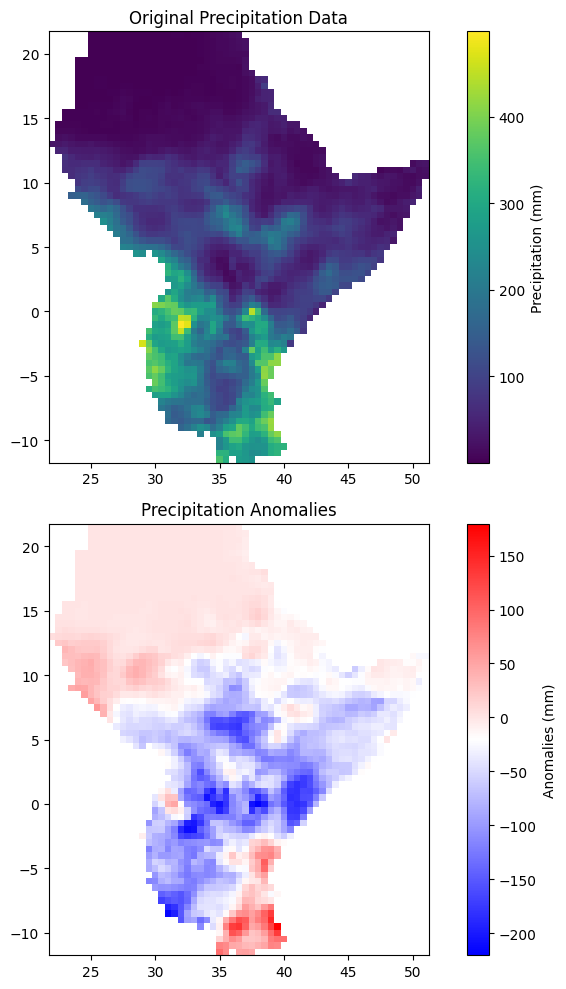

In [7]:
validate_anomalies1(prec_data, anomalies, lat, lon)

Visualize and compare original and transformed precipitation anomalies for a single year.

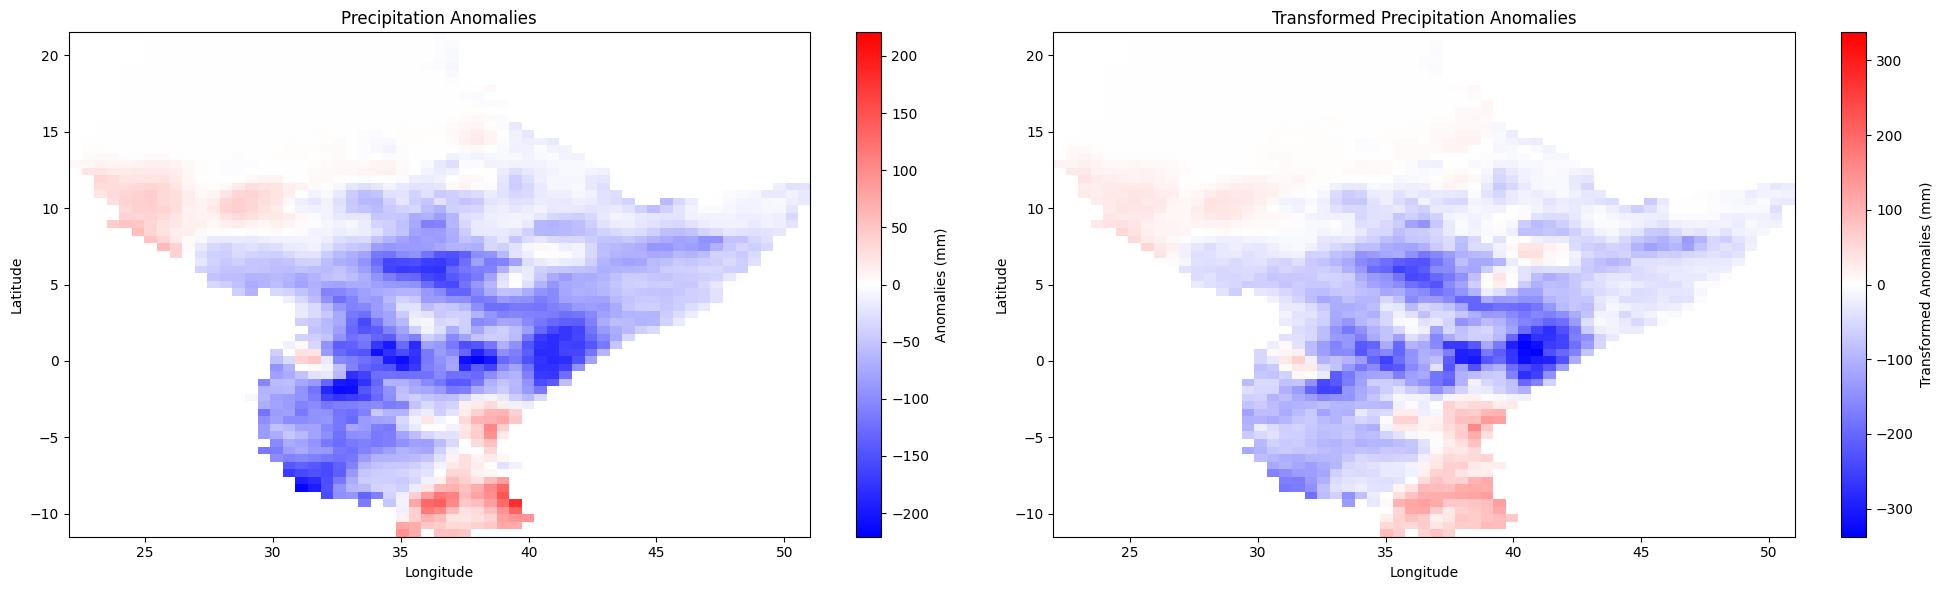

In [8]:
validate_anomalies2(anomalies, anomalies_normal, lat, lon)

Visualize and compare the distribution of original and transformed precipitation anomalies using histograms.

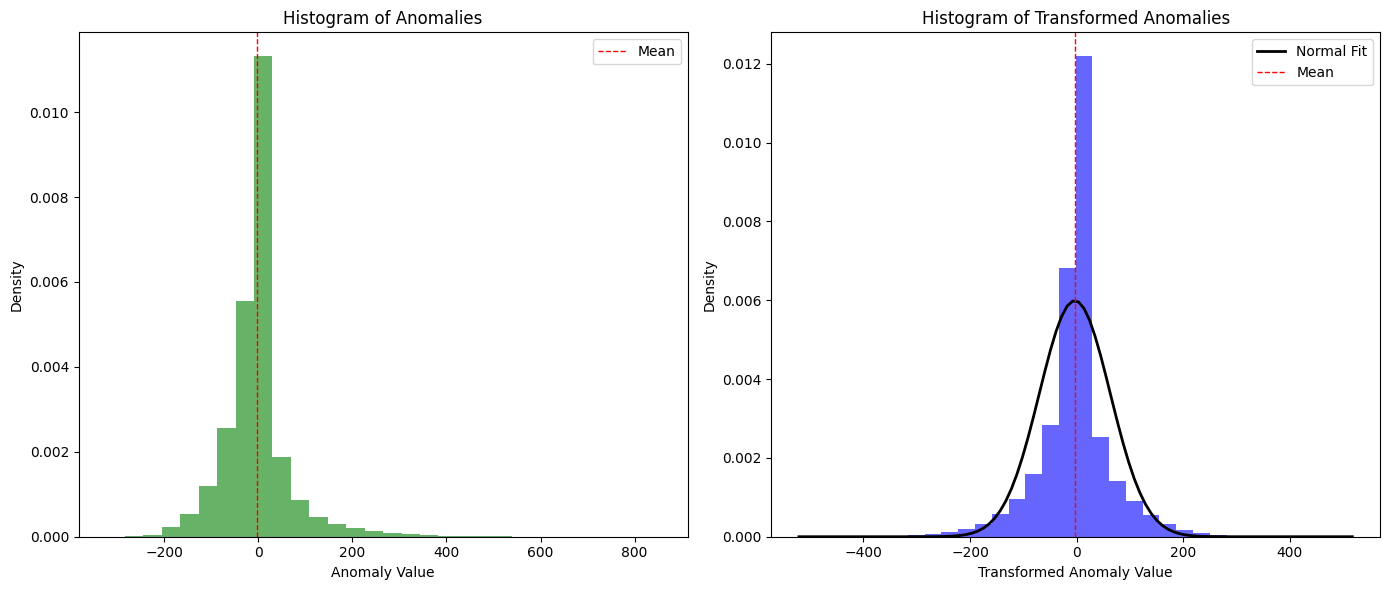

In [9]:
validate_anomalies3(anomalies, anomalies_normal)

Print statistical information about the original and transformed precipitation anomalies.

In [10]:
validate_anomalies4(anomalies, anomalies_normal)

Printing some information about anomalies.
Anomalies - mean: -3.7547226 std: 70.41291
Transformed Anomalies - mean: -3.5519643 std: 66.59065
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 76200
NaN values in transformed anomalies: 76200


##### Get/Calculate EOFs, Factor Loadings and Variance Fractions

In [11]:
# Get EOFs, PCs and variance fractions
if not path.exists(f'{eof_dir}chirps_eofs_{season}.nc'):
    eofs, pcs, var_fracs = compute_eofs_pcs(anomalies_normal, n_eofs) # Calculate EOFs
    eofs_reshaped = eofs.reshape((n_eofs, len(lat), len(lon)))
    save_eofs_pcs(eofs_reshaped, pcs, var_fracs, year, lat, lon, eof_dir, season) # Save EOFs, PCs and variance fractions
else:
    eofs_reshaped = xr.open_dataarray(f'{eof_dir}chirps_eofs_{season}.nc', engine='netcdf4').values
    pcs = xr.open_dataarray(f'{eof_dir}chirps_pcs_{season}.nc', engine='netcdf4').values
    var_fracs = xr.open_dataarray(f'{eof_dir}chirps_var_fracs_{season}.nc', engine='netcdf4').values
    
print("Normalized Anomalies EOFs Shape:", eofs_reshaped.shape)
print("Normalized Anomalies PCs Shape:", pcs.shape)
print("Normalized Anomalies Variance Fraction:", var_fracs, "\nSum: ", var_fracs.sum())

Normalized Anomalies EOFs Shape: (7, 67, 59)
Normalized Anomalies PCs Shape: (40, 7)
Normalized Anomalies Variance Fraction: [0.58292407 0.08870358 0.06472777 0.0403917  0.02758382 0.02055334
 0.01733564] 
Sum:  0.84221995


##### Plots to Ensure Successful Calculation of EOFs, Factor Loadings and Variance Fractions

Visualize the Empirical Orthogonal Functions (EOFs) as a series of plots.

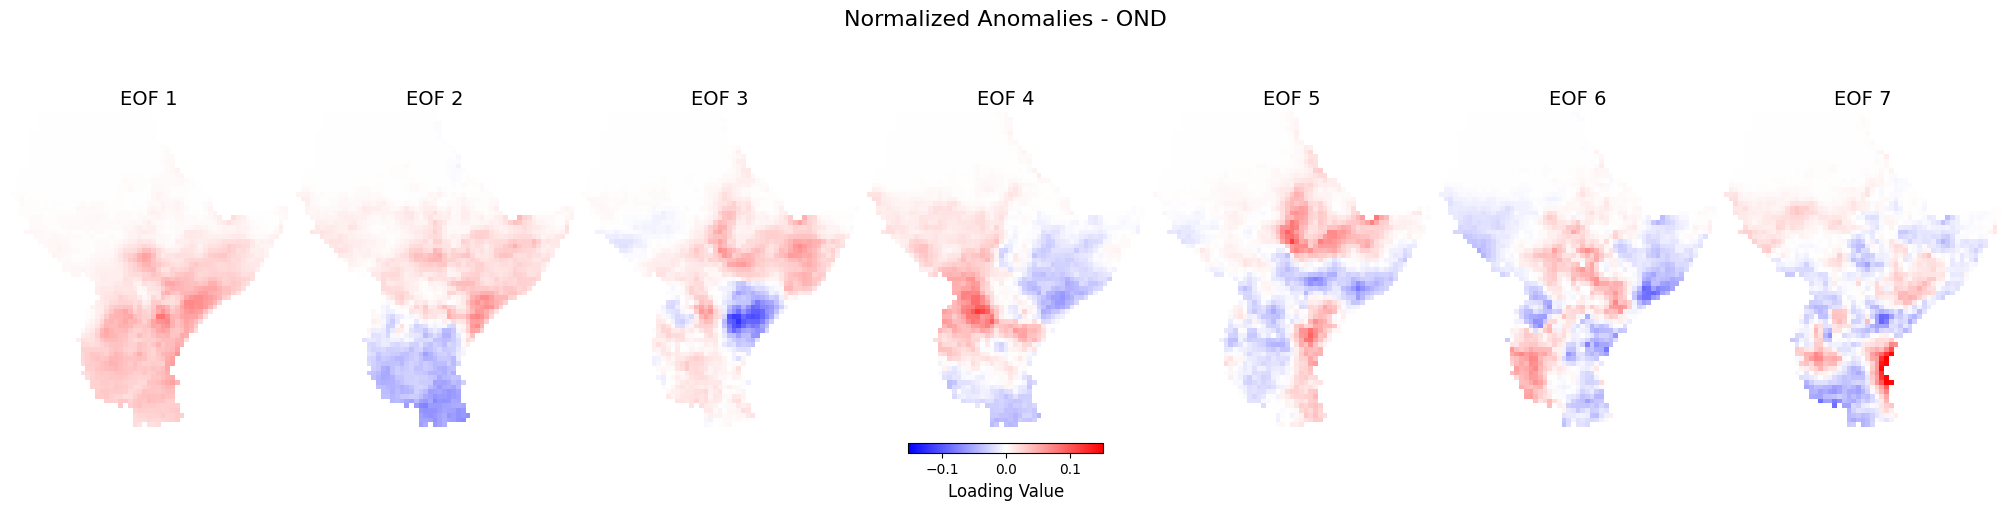

In [12]:
validate_eofs(eofs_reshaped, f"Normalized Anomalies - {season}", n_eofs)

Validate the principal components (PCs) by comparing calculated PCs with reference time series.

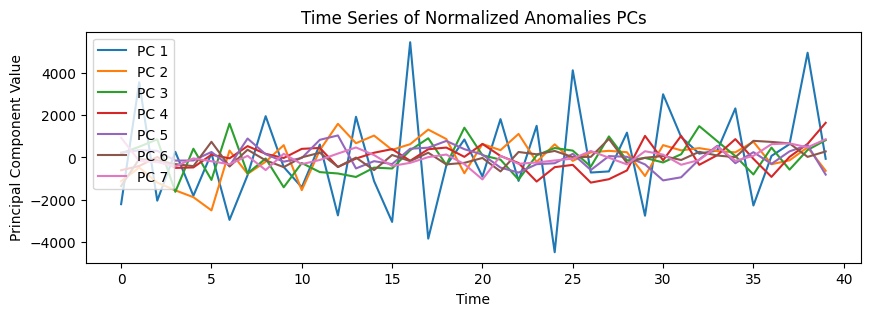

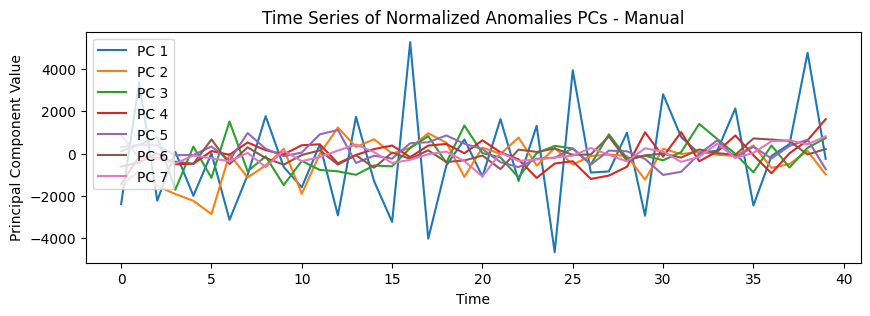

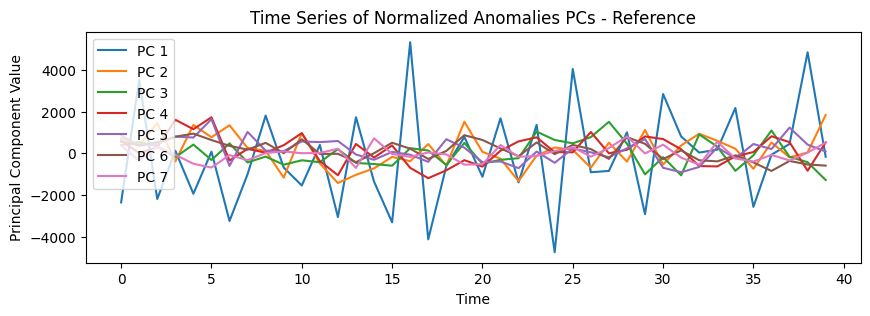

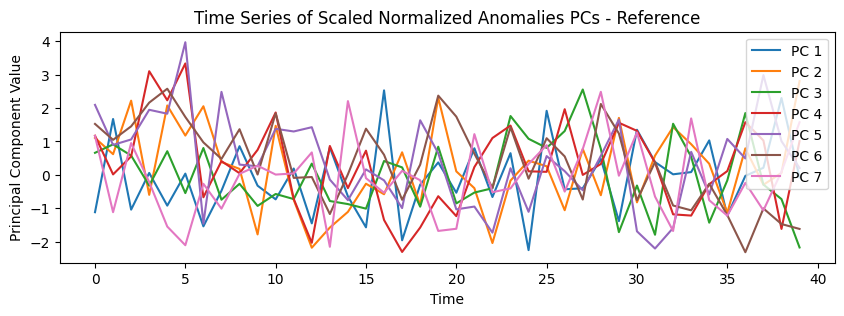

In [13]:
validate_pcs(anomalies_normal, eofs_reshaped, pcs, lat, lon, year, period_train, season, n_eofs)

#### Load and Process ERA5 Data

Load era5 indices if available. Otherwise load ERA5 data, calculate indices, and save out.

In [14]:
load_years = [*range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))]

In [15]:
# Load sst data
sst_data = load_raw_data(era5_dir, "sst", load_years, season)
sst_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [16]:
# Load uwind200 data
uwind200_data = load_raw_data(era5_dir, "uwind200", load_years, season)
uwind200_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [17]:
# Load uwind850 data
uwind850_data = load_raw_data(era5_dir, "uwind850", load_years, season)
uwind850_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

##### Get/Calculate ERA5 Indices

In [18]:
era5_indices_path = f'{indices_dir}era5_indices.nc'
months = list(range(1, 13))

if not path.exists(era5_indices_path):
    era5_indices = get_all_indices(sst_data, uwind200_data, uwind850_data, period_clm, period_train, months) # Calculate indices
    
    ds = era5_indices.set_index(['year', 'month']).to_xarray() # Convert DataFrame to xarray Dataset for saving
    print("Saving indices...")
    ds.to_netcdf(era5_indices_path) # Save the Dataset to a NetCDF file
    print(f"Data saved to {era5_indices_path}")
    print(era5_indices.head) # Print the first few rows of the DataFrame to verify
else:
    ds_loaded = xr.open_dataset(era5_indices_path, engine='netcdf4') # Load the NetCDF file into an xarray Dataset
    print(f"Data loaded from {era5_indices_path}")
    era5_indices = ds_loaded.to_dataframe().reset_index() # Convert the xarray Dataset back to a DataFrame
    print(era5_indices.head) # Print the first few rows of the DataFrame to verify

Data loaded from /nr/samba/user/ahellevik/CONFER-WP3/validation_data/indices/era5_indices.nc
<bound method NDFrame.head of      year  month       n34        n3        n4       dmi  n34_diff1  \
0    1981      1 -0.878076 -1.105121 -0.610689  0.347750   0.000000   
1    1981      2 -1.194670 -1.445646 -0.814860 -0.049903  -0.310888   
2    1981      3 -1.183618 -1.445331 -0.922555 -0.561697   0.010853   
3    1981      4 -1.678912 -1.919827 -0.753611  0.522551  -0.486369   
4    1981      5 -1.349333 -1.029916 -0.773688 -1.361840   0.323640   
..    ...    ...       ...       ...       ...       ...        ...   
475  2020      8 -0.769404 -0.739564 -0.778996 -0.922866  -0.345186   
476  2020      9 -1.014953 -1.199928 -0.985926 -0.770179  -0.241124   
477  2020     10 -1.263689 -1.201887 -1.209699  0.172647  -0.244254   
478  2020     11 -1.150069 -1.008953 -1.061598 -0.620625   0.111573   
479  2020     12 -0.849050 -0.660425 -1.115174 -0.103469   0.295595   

     dmi_diff1       wsp

##### Plots to Ensure Successful Calculation of ERA5 Indices

Plot time series of each index comparing with reference, and print some numbers for additional validation.

Validating index: dmi


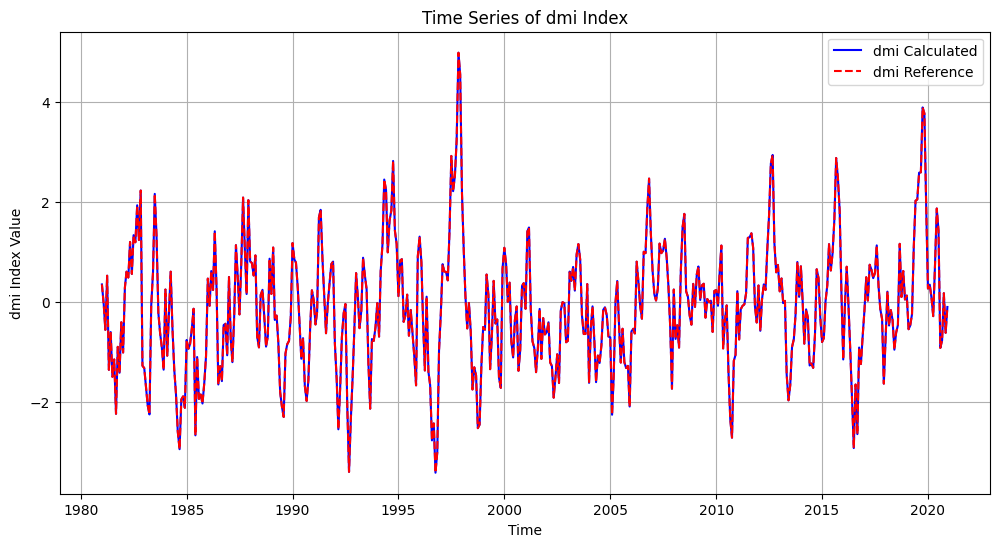

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 1.9419364929199219
Reference value: 1.9418332171625


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.2652451992034912
Reference value: 0.265314241227996


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.3432576656341553
Reference value: 0.343302725351841


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.08859562873840332
Reference value: 0.0886621333093891


Validating index: dmi_diff1


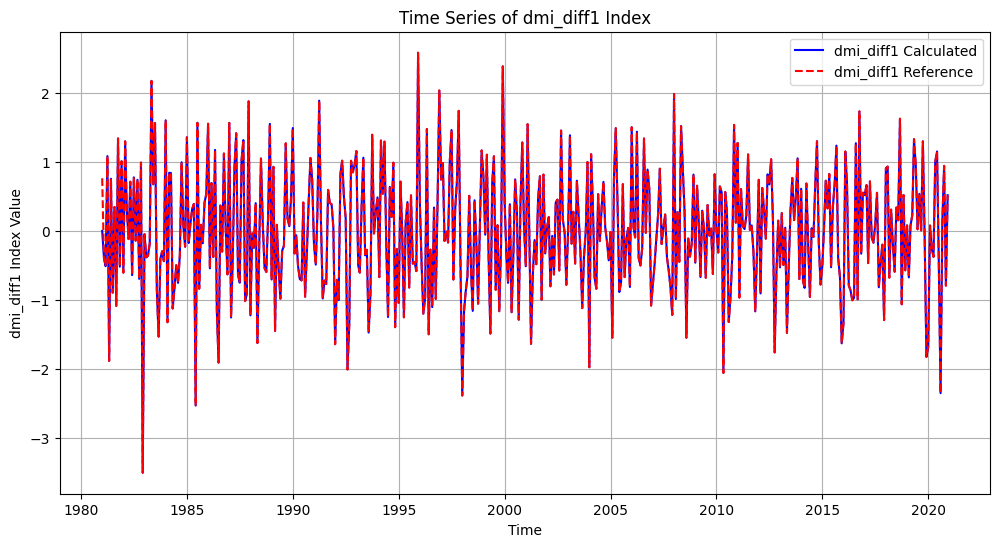

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.8267383575439453
Reference value: -1.82678177870107


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -1.6766912937164307
Reference value: -1.6765189759345


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.07801246643066406
Reference value: 0.0779884841238445


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.25466203689575195
Reference value: -0.254640592042452


Validating index: n3


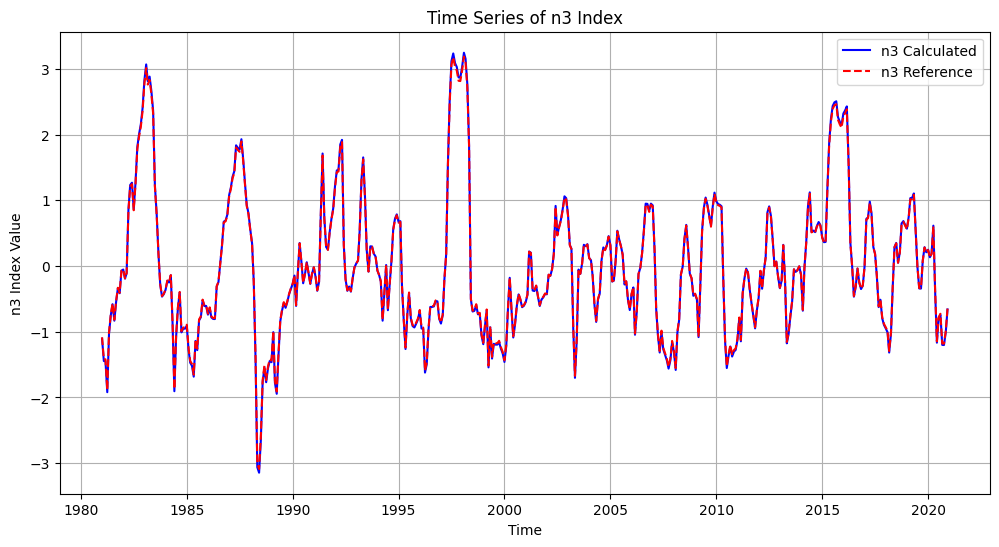

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.20983758568763733
Reference value: 0.206019603912169


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.2482137680053711
Reference value: 0.243756788163554


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.13393370807170868
Reference value: 0.13158023441094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.18719516694545746
Reference value: 0.183879605622572


Validating index: n34


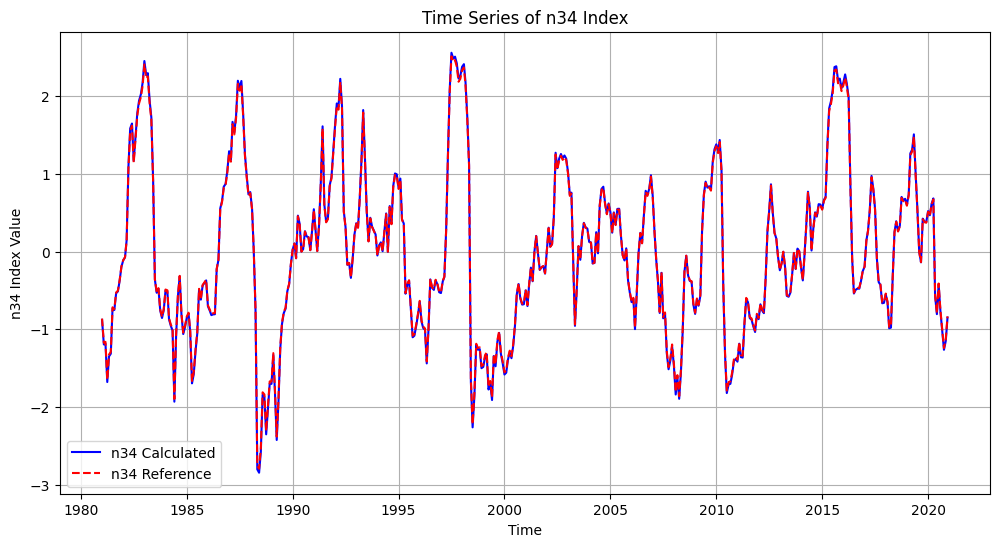

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.37987130880355835
Reference value: 0.372994201030477


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.522404134273529
Reference value: 0.513009703875565


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.4692562520503998
Reference value: 0.460850765524855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.6152685284614563
Reference value: 0.604228159008709


Validating index: n34_diff1


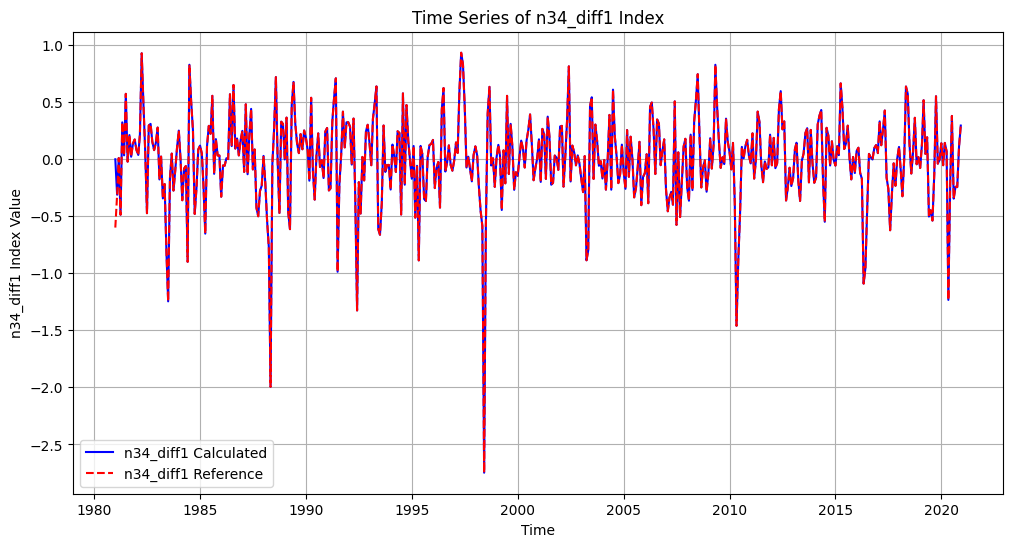

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -0.005655646324157715
Reference value: -0.0056419748808896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.1399645209312439
Reference value: 0.140015502845088


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -0.05219024419784546
Reference value: -0.0521589383507099


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.1433812379837036
Reference value: 0.143377393483854


Validating index: n4


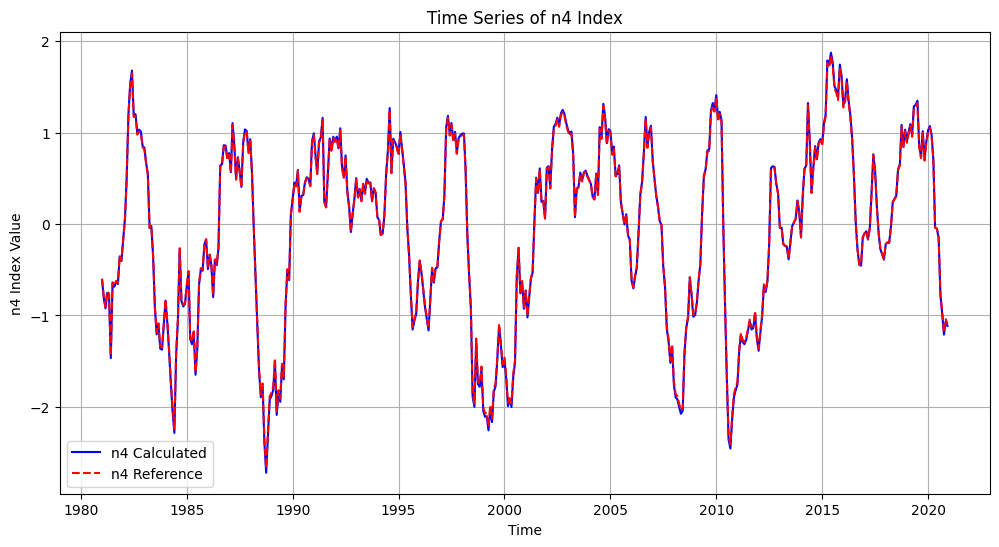

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.8953214883804321
Reference value: 0.879144916265894


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 1.024899959564209
Reference value: 1.00643704571476


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 1.0707846879959106
Reference value: 1.05155372046276


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.9801605939865112
Reference value: 0.96257094914962


Validating index: sji200


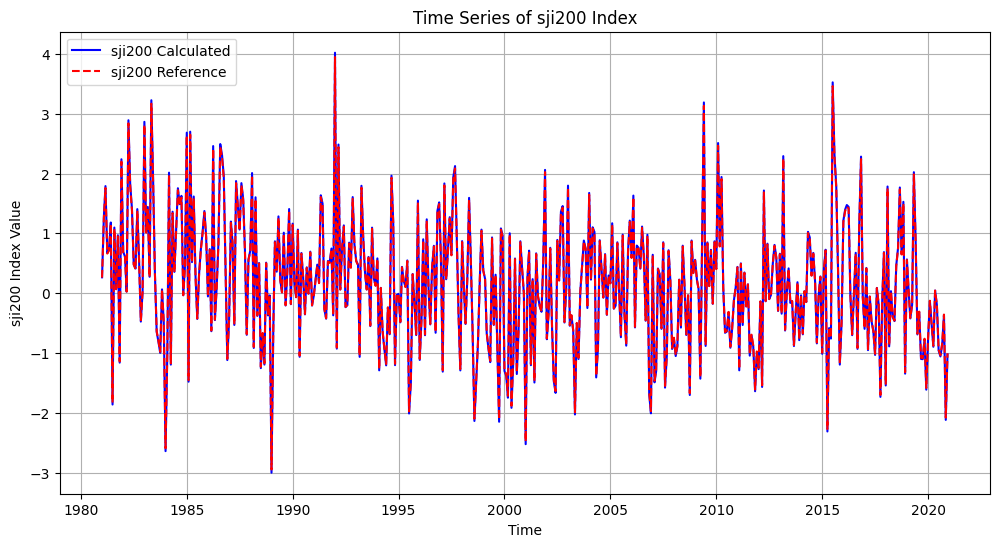

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.6115000247955322
Reference value: -1.58246167948365


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -0.7603710889816284
Reference value: -0.746669580627106


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -0.12836050987243652
Reference value: -0.126047556243128


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.5111793875694275
Reference value: -0.501968169565544


Validating index: sji850


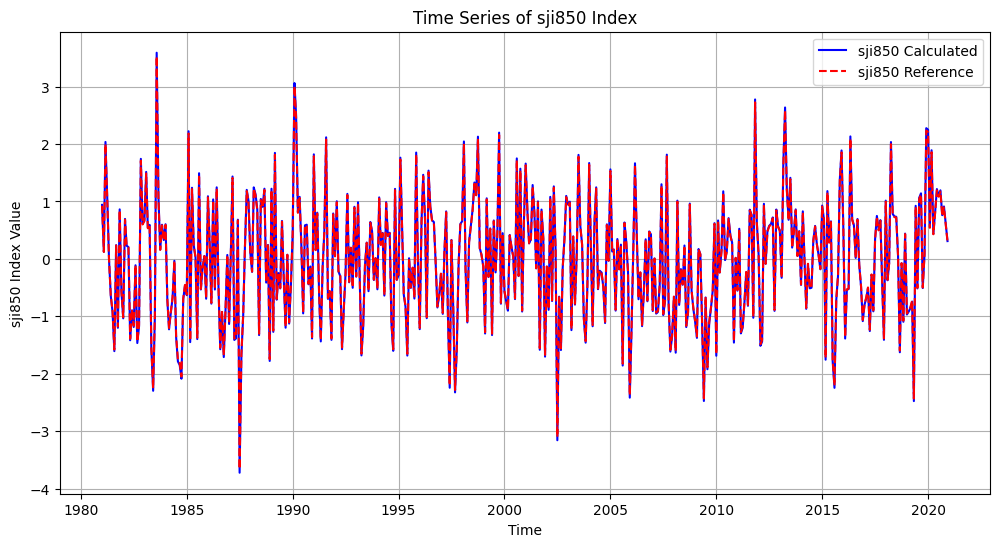

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 2.2761528491973877
Reference value: 2.23513716972386


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 2.2494091987609863
Reference value: 2.20887629889085


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.5522845387458801
Reference value: 0.542333684632671


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.8918044567108154
Reference value: 1.85771575568932


Validating index: ueq200


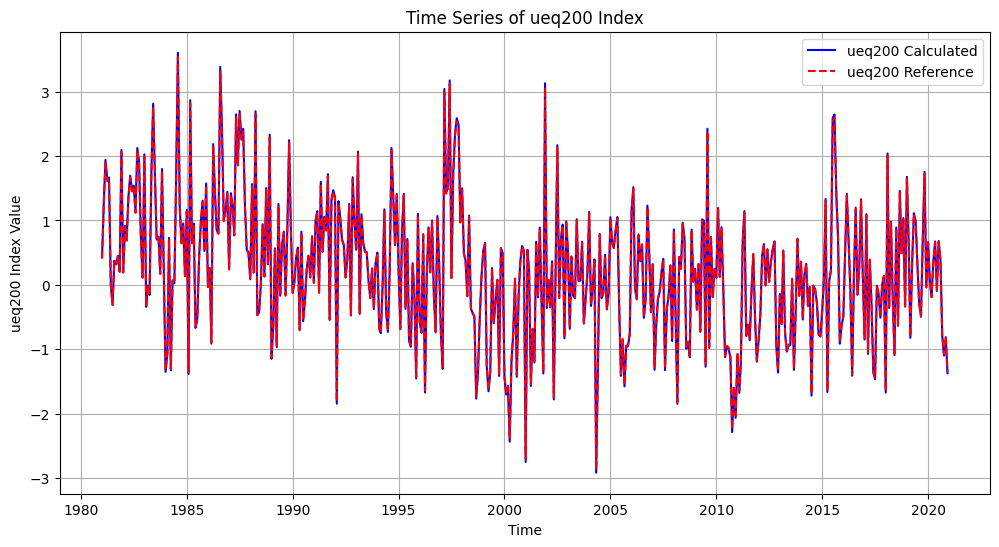

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -0.03881261497735977
Reference value: -0.0381129128773105


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.6620338559150696
Reference value: 0.65010424548631


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.05884569510817528
Reference value: 0.0577853047959282


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.19194722175598145
Reference value: -0.188488269519044


Validating index: ueq850


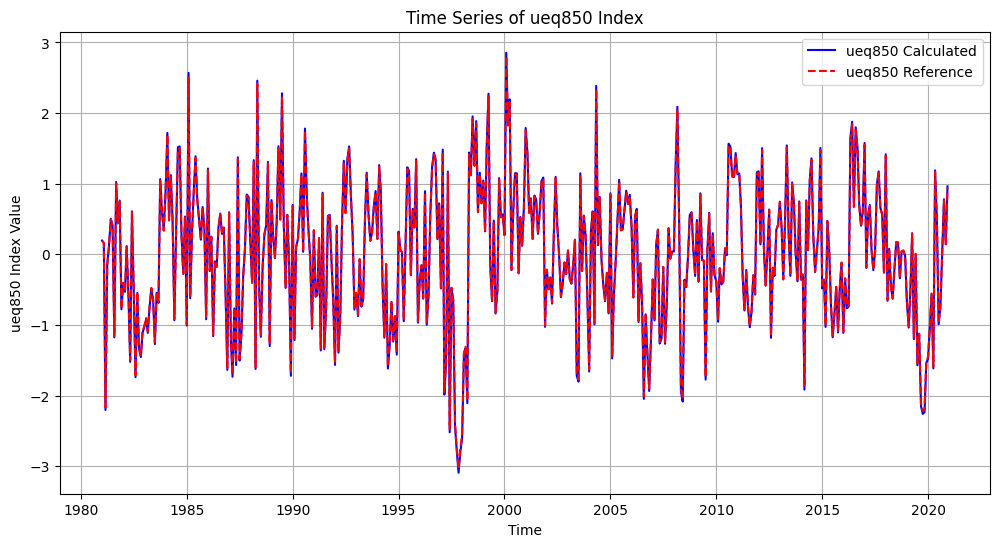

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.5403413772583008
Reference value: -1.51258507670805


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -1.473352313041687
Reference value: -1.44680336146896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -1.0252622365951538
Reference value: -1.0067874838614


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.5642094612121582
Reference value: -0.554042589497677


Validating index: wnp


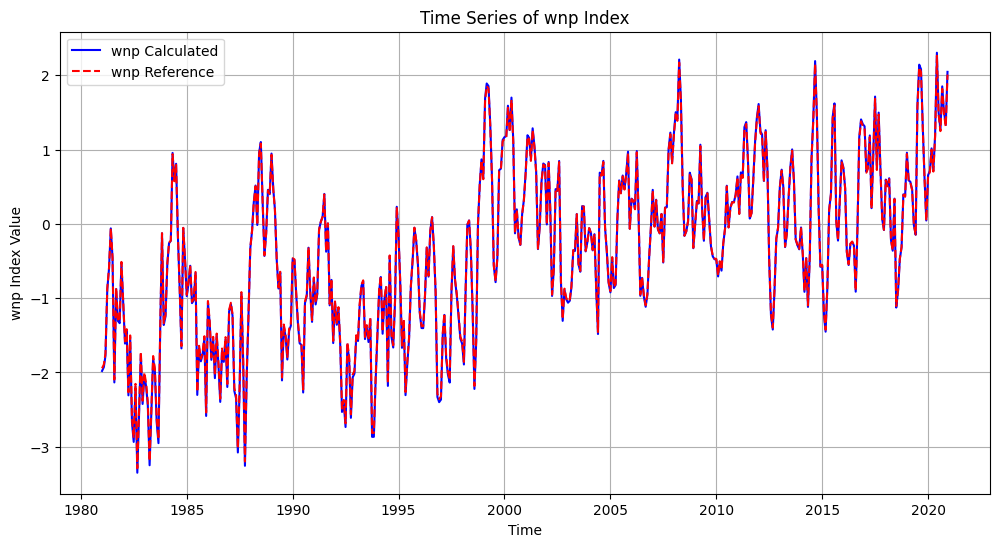

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.044872310012578964
Reference value: 0.0439991073142581


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.653798520565033
Reference value: 0.642058242147582


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.7116570472717285
Reference value: 0.698954206422623


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.0151039361953735
Reference value: 0.99688132465


Validating index: wp


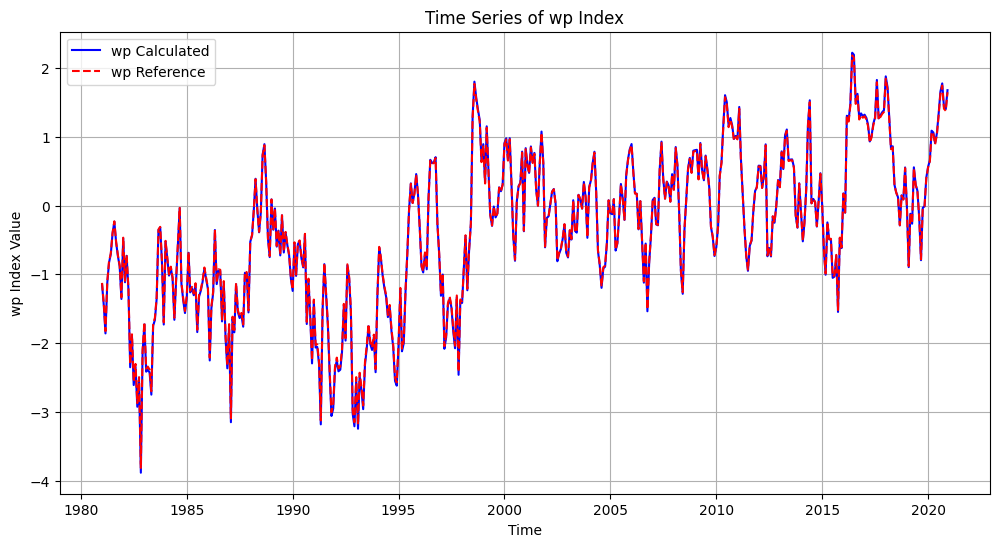

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.4036230146884918
Reference value: 0.3965014406094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.5627392530441284
Reference value: 0.552468608350522


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.6579357385635376
Reference value: 0.645874754009963


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.0894144773483276
Reference value: 1.06964466368143


Validating index: wpg


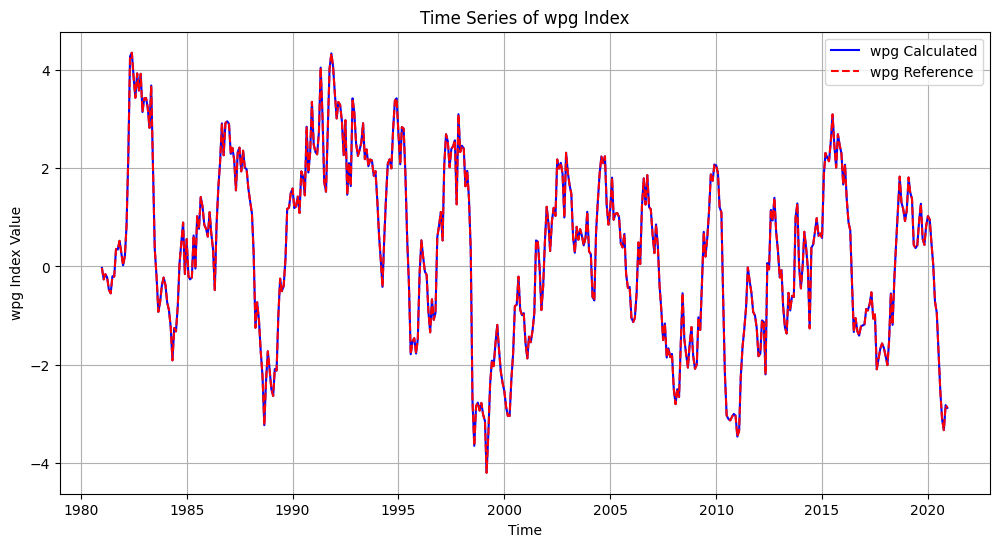

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.8253048062324524
Reference value: 0.8253758807116


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 1.0249437093734741
Reference value: 1.02486499573251


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.952954888343811
Reference value: 0.952911481535054


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.48157668113708496
Reference value: 0.481602647259719


Validating index: wsp


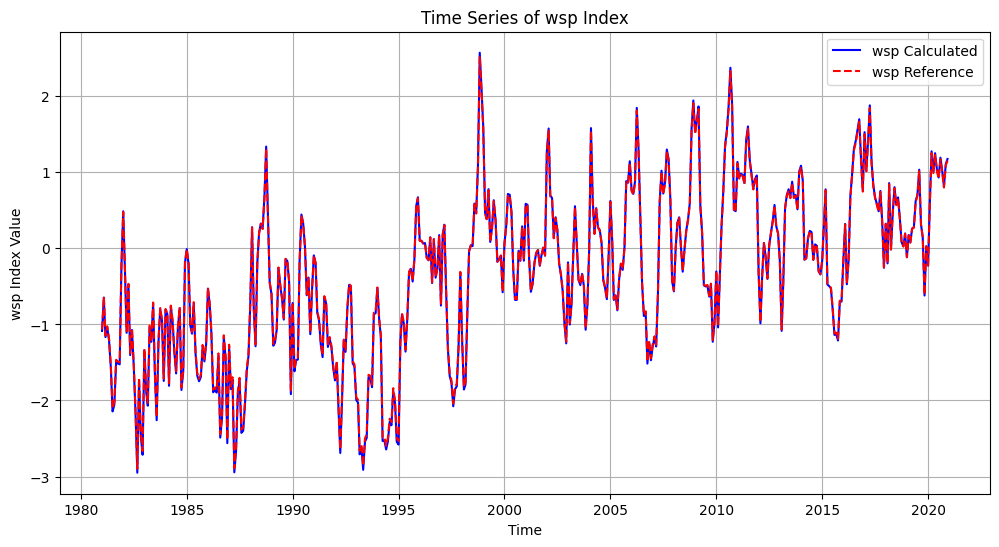

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.026800455525517464
Reference value: 0.0263166023317855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -0.2280745953321457
Reference value: -0.223977062664927


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.6117443442344666
Reference value: 0.600790106588463


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.2746162414550781
Reference value: 1.25162967063952


Validating index: wvg


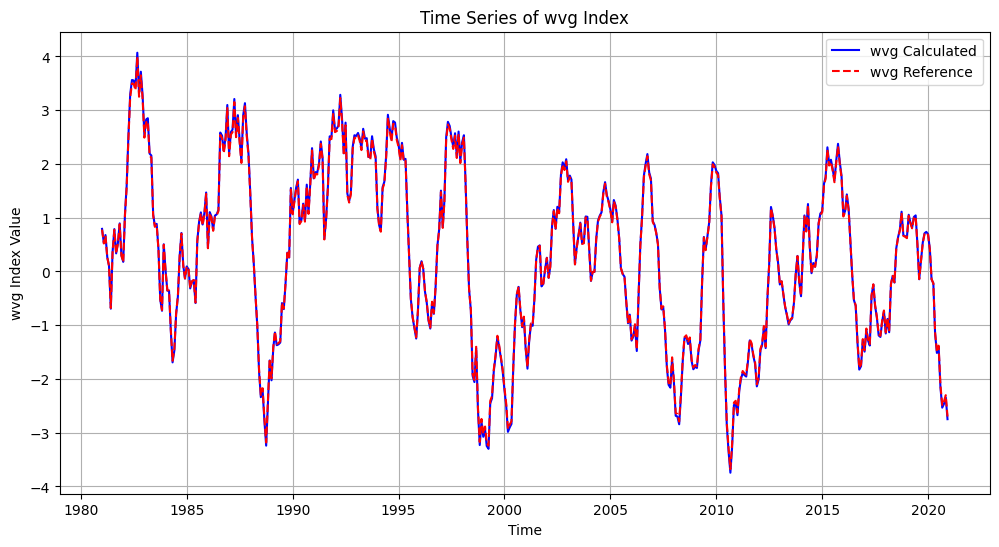

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.7368895610173544
Reference value: 0.72353919951408


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.6954122583071392
Reference value: 0.682920449770368


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.41033899784088135
Reference value: 0.403014031455744


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.14621762434641528
Reference value: -0.14348093717403




In [19]:
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'
validate_indices(era5_indices, filepath_indices, period_train, year_fcst)

#### Train ML Model

Load model coefficients and covariances if available, otherwise train model and save out.

##### Get/Train ML Model

In [20]:
feature_names = ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']

# Get model coefficients and covariances, or train model
if not path.exists(f'{ml_dir}model_coefficients_{season}_month_{month_init}.nc'):
    df_coefficients, df_fl_pred_cov = get_ml_results(era5_indices, feature_names, pcs, var_fracs, n_eofs, period_train, period_clm, month_init)
    save_model_results(df_coefficients, df_fl_pred_cov, ml_dir, season, month_init, n_eofs)
else:
    df_coefficients = xr.load_dataset(f'{ml_dir}model_coefficients_{season}_month_{month_init}.nc').to_dataframe()
    
    cov_ds = xr.load_dataset(f'{ml_dir}prediction_covariances_{season}_month_{month_init}.nc')
    cov_array = cov_ds.covariance.values
    years = cov_ds.year.values
    
    # Reconstruct df_fl_pred_cov
    df_fl_pred_cov = pd.DataFrame(
        index=years,
        columns=[f'cov-{i}{j}' for i in range(1, n_eofs + 1) for j in range(1, n_eofs + 1)],
        data=cov_array.reshape(len(years), -1)
    )
print(df_coefficients)
print(df_fl_pred_cov)  

             year  n34         dmi  wvg  wsp         wpg   wp  dmi_diff1  \
index                                                                      
eof1   265.388018  0.0  385.090923  0.0  0.0  360.404784  0.0        0.0   
eof2   158.043862  0.0   32.912283  0.0  0.0   29.961810  0.0        0.0   
eof3    62.959550  0.0   57.845929  0.0  0.0  -26.487438  0.0        0.0   
eof4    36.028576  0.0   32.819137  0.0  0.0  -31.638028  0.0        0.0   
eof5   -60.856525  0.0  -25.944303  0.0  0.0    9.662367  0.0        0.0   
eof6    89.664591  0.0    4.868426  0.0  0.0  -29.814677  0.0        0.0   
eof7    51.206404  0.0   30.666857  0.0  0.0  -21.905442  0.0        0.0   

       sji850      sji200  
index                      
eof1      0.0  125.392626  
eof2      0.0  -26.711700  
eof3      0.0   13.143646  
eof4      0.0   -2.062481  
eof5      0.0   -7.737864  
eof6      0.0   13.498115  
eof7      0.0  -31.820588  
            cov-11         cov-12         cov-13        cov-14 

##### Plots to Ensure Successful Training of ML Model

Validate and visualize the machine learning model coefficients.

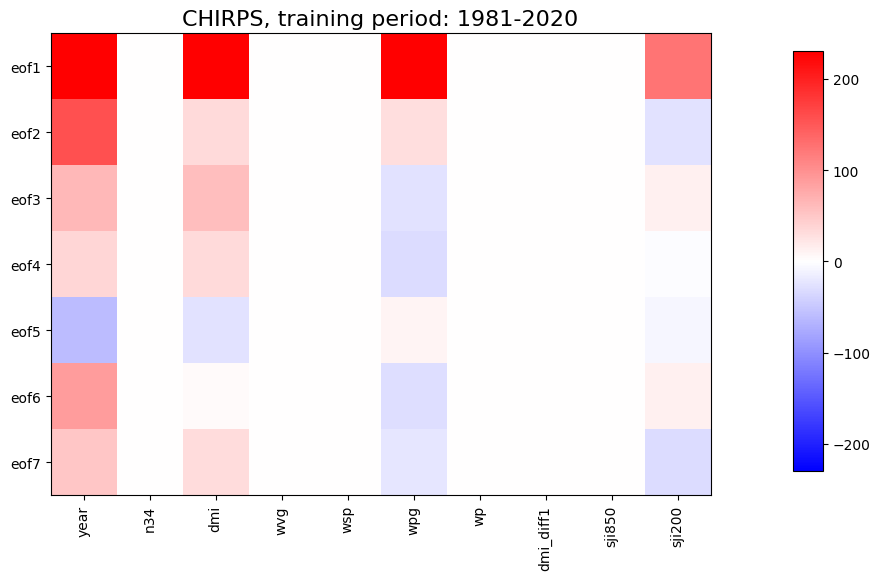

In [21]:
validate_ml_coefficients(df_coefficients, period_train, season, month_init)

Plot tercile probability forecast as both two plots (above and below normal) and one combined plot. Validate the precipitation forecast against actual data by comparing predicted categories with actual categories.
The plots of combined tercile probabilities currently never displays values in the normal category. I am not sure why, but I think this is most likely due to the values of prob_bn and prob_an coming from calculate_tercile_probability_forecasts always being too high to let normal become the largest category.

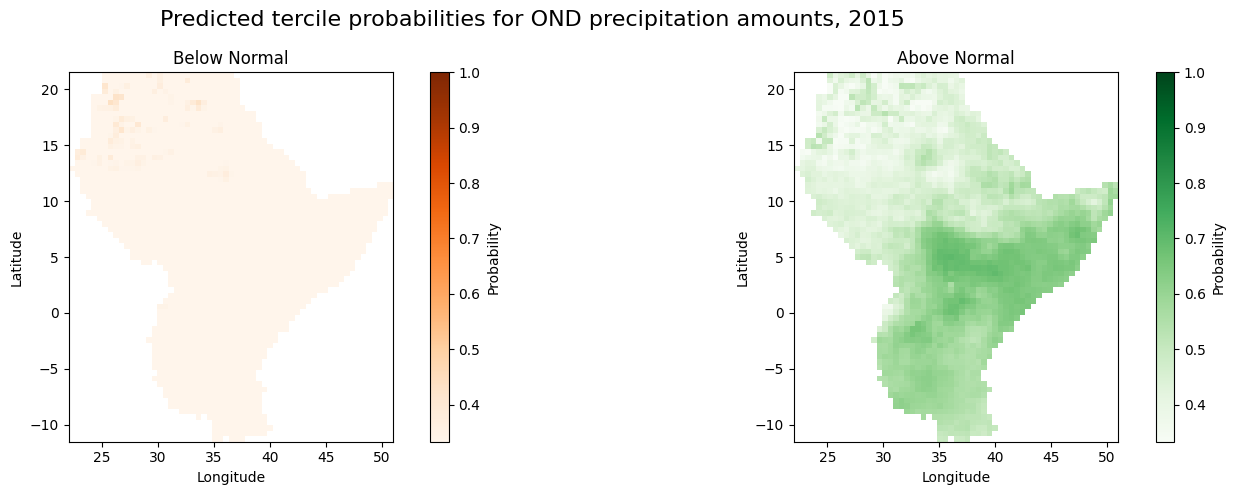

0.2416176807285002
0.2559054762866422
0.2527849544803463
0.24554245037062938
0.25206069217392457
0.2452238791392487
0.24814504855907038
0.24725407208425998
0.24286432752103626
0.2464005673048334
0.23916292262640493
0.2434137185779892
0.23732624092195698
0.2571403244763649
0.25223606657074926
0.24604009363108303
0.2436423811695736
0.2451978117906184
0.2703011474393576
0.26097205606517804
0.2836977940004468
0.2660208191739819
0.2770387454257778
0.2882573643994749
0.29143450341978094
0.2672599858515359
0.2591531168454454
0.24537641184197212
0.25561296160627234
0.2538385754979382
0.26800048786684627
0.27659531781406044
0.2798699950096951
0.2817229451990646
0.28507190649581804
0.2863802611024686
0.2833462015019006
0.2892932886784173
0.28271524678500626
0.2866764125631933
0.30169479979961267
0.301612018513955
0.2913962920278226
0.28878348739540205
0.289973691810432
0.30233259369498156
0.30121601041110035
0.31376934445074434
0.3006998604330391
0.2963632226117052
0.2987748112323647
0.303995710

/nr/samba/user/ahellevik/CONFER-WP3/src/confer_wp3/plotting.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


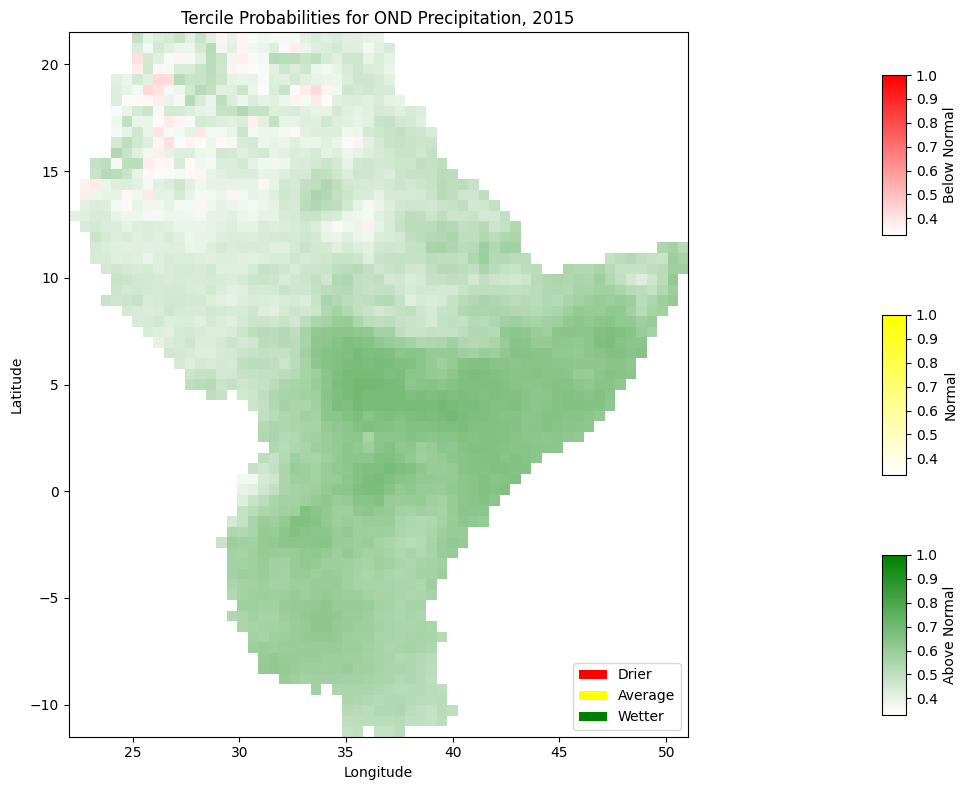

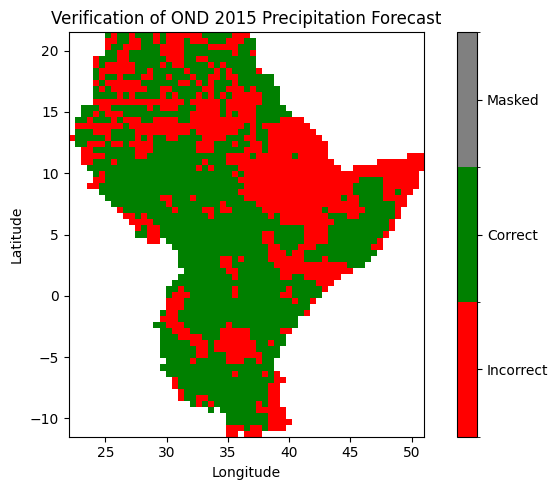

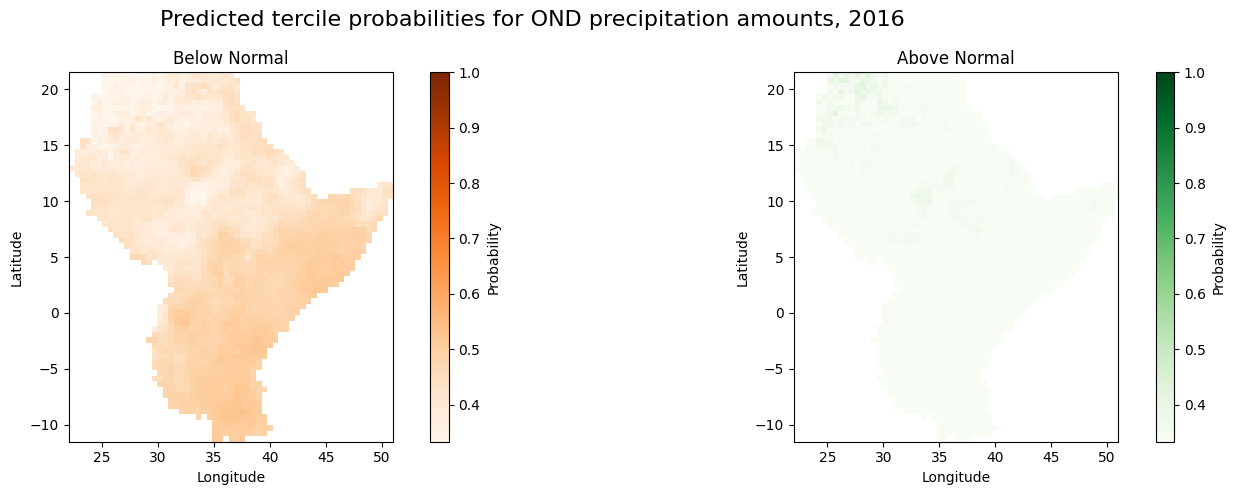

0.2377745762090122
0.2555347274656976
0.2505404675571391
0.24898636660751117
0.2525484355270644
0.24967680629992528
0.2499795630119599
0.24977940611022953
0.2562314714040099
0.2586766965615388
0.2570907396393799
0.2644507955630848
0.26089302162659345
0.27541026794655377
0.27324702880137797
0.276172364072909
0.27395410768326967
0.2713157819374654
0.27701546841102953
0.2818827279729854
0.29135822959328694
0.2786405569379149
0.27981941366864294
0.2896391823339871
0.2912677320259385
0.27222590295186355
0.27327615872741273
0.273724773669052
0.2820043843848594
0.27323354556239554
0.28137920412091144
0.2851779862621294
0.28714630192500723
0.29102772266573673
0.298103149759006
0.2964006337165894
0.3015162727912444
0.2980807538282425
0.2903791095977428
0.2901432046861052
0.3046835282732465
0.30605371332763354
0.2984964248677602
0.29944694236728275
0.29880299968453405
0.311998240011892
0.31163423205453056
0.3147168677216331
0.29700303113488424
0.3011556611001376
0.297686402161924
0.3034582283849

/nr/samba/user/ahellevik/CONFER-WP3/src/confer_wp3/plotting.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


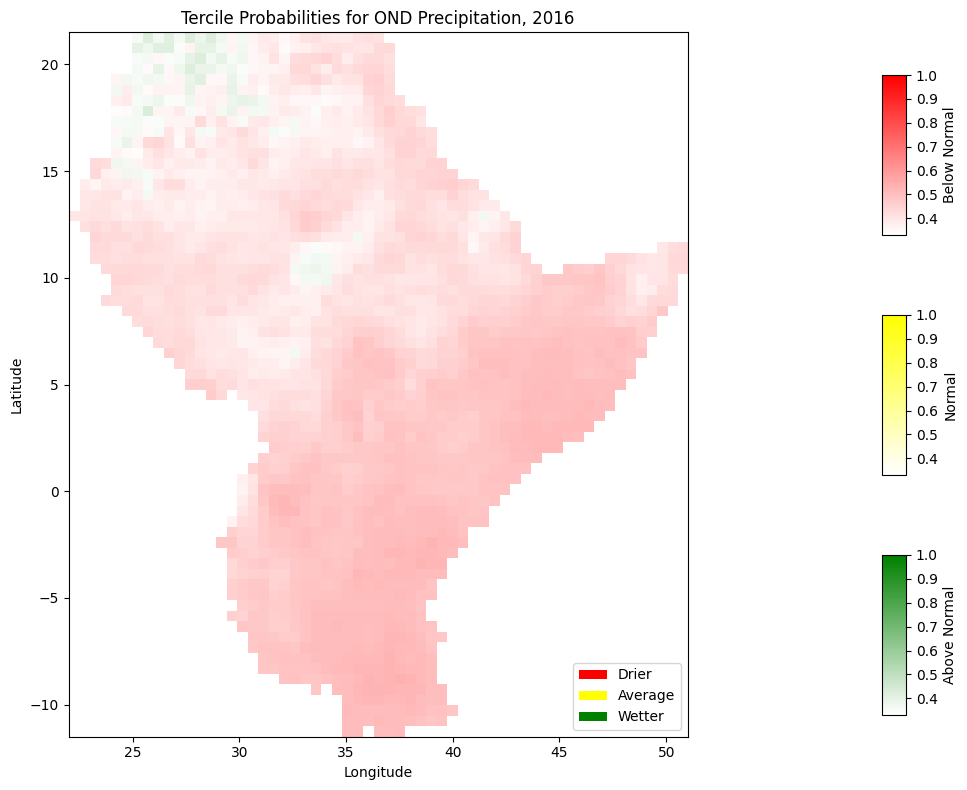

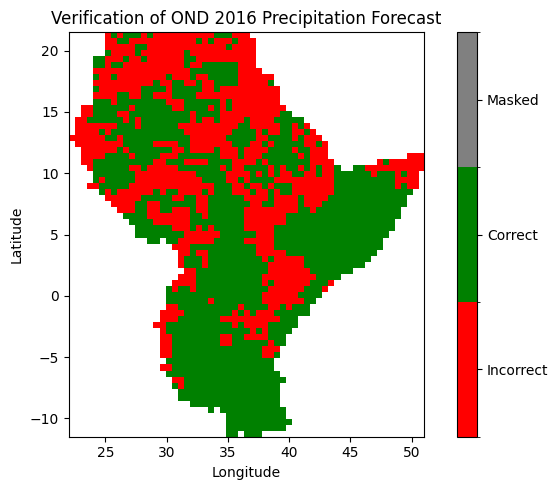

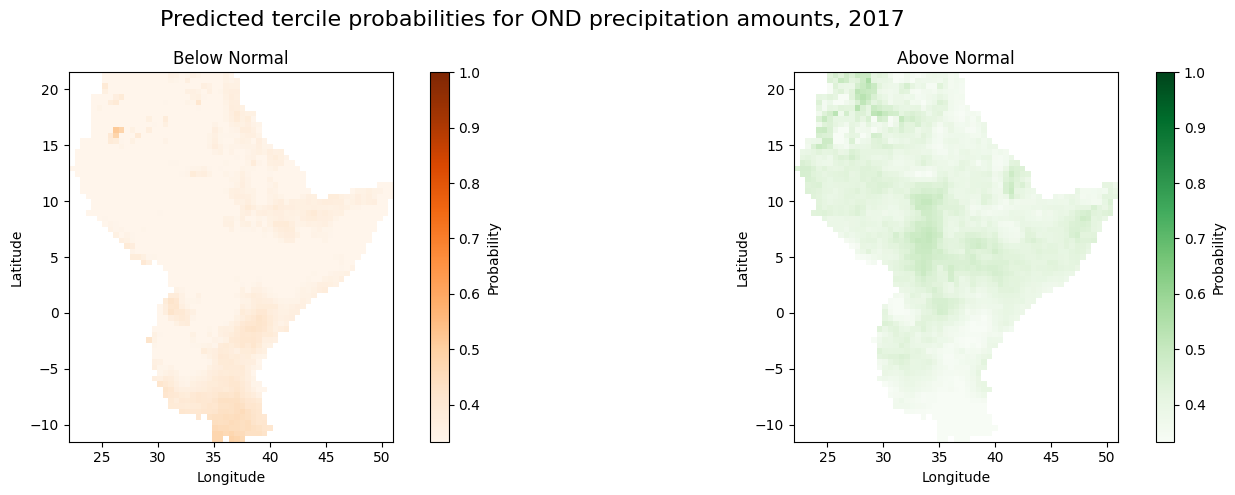

0.24580490650001752
0.26261925715801204
0.2618460595868768
0.26103755417541996
0.26590187588774805
0.2587527977094206
0.26213325831815526
0.2636868725005833
0.2679267489297614
0.26713599695251733
0.26581913103664057
0.27017889791018557
0.26768701876174406
0.28342898747539613
0.2810551790438003
0.27859191004132966
0.2771887677182714
0.27700171383928285
0.28255364853330533
0.2876137204654208
0.2884159504752566
0.27441695597821447
0.2773501925558962
0.2862464723246094
0.2907253258626512
0.27861963832387326
0.28294821256941205
0.28535045687569016
0.29121251122544933
0.2787591906566531
0.2819280077422005
0.28472398127481535
0.2872403750924233
0.29566921648693223
0.2955113440529419
0.29258902179055557
0.2937532809448191
0.29497709815961304
0.2882678417764879
0.29011691797069006
0.30497652326809677
0.30592266662862444
0.29723452889682167
0.2912473481862703
0.2903284893478759
0.3025217242894468
0.30838414494673994
0.31526806029724685
0.30144015211356
0.30405742234648125
0.2976399389345876
0.30

/nr/samba/user/ahellevik/CONFER-WP3/src/confer_wp3/plotting.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


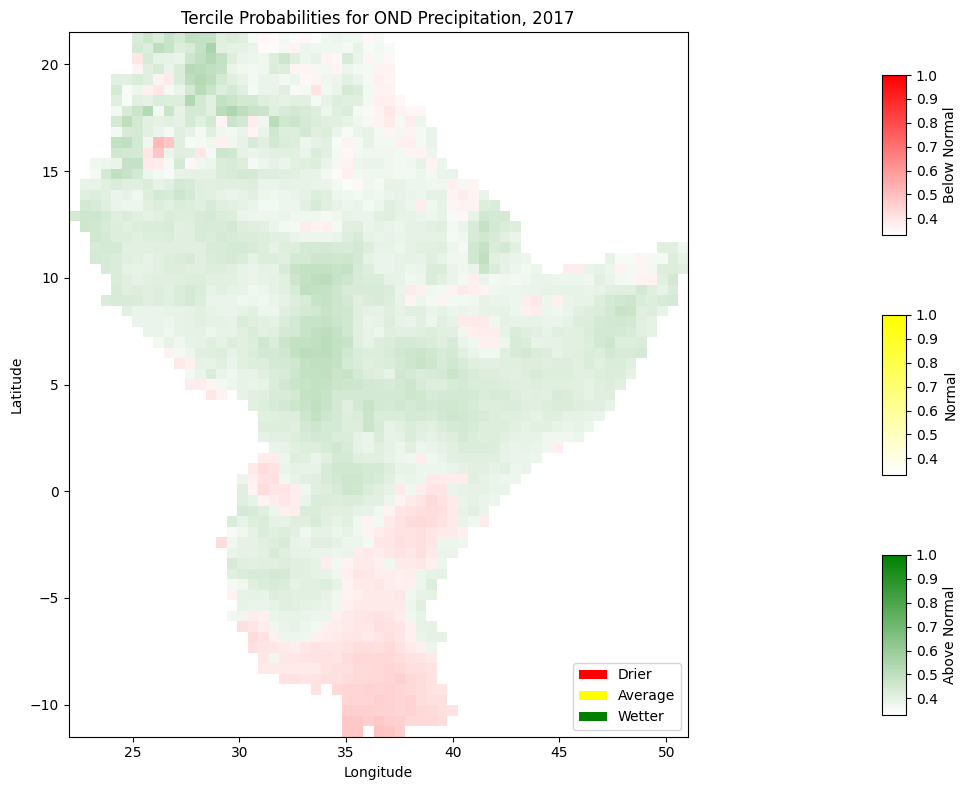

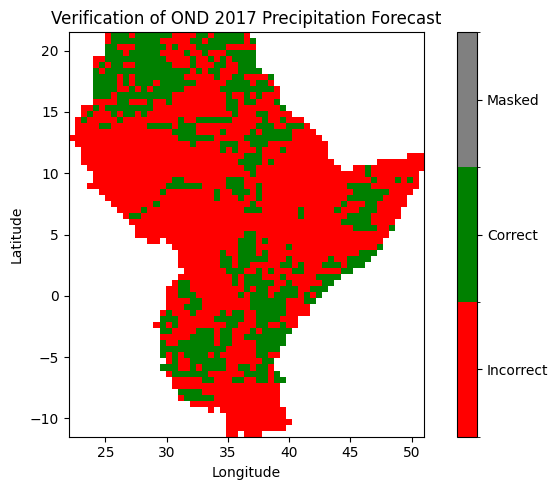

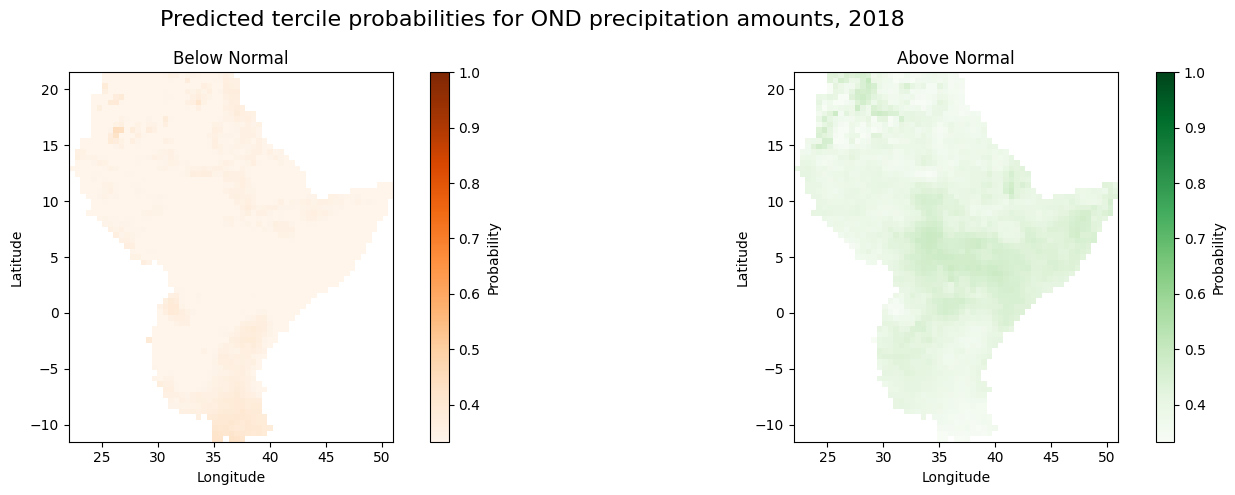

0.25080500615797097
0.2659075752237985
0.2650986358860803
0.26247453692403644
0.26686259191747685
0.25958053935900294
0.26306620818692905
0.2640936791905545
0.26756540554000163
0.26725704017450425
0.2646214360454363
0.2692250050399154
0.2666051325908403
0.2830261463381212
0.2802849624895325
0.2780111327213134
0.2766977056941562
0.2765614160402122
0.2815445910811847
0.2868829248584057
0.2889786396221963
0.2773587468467593
0.27929235028918353
0.28896718561538504
0.29148467192802885
0.2791666885592632
0.2805236322647444
0.2838566824881211
0.29028061045986786
0.2772977748582006
0.28217336319157205
0.2856483083479071
0.28769488758685813
0.2954878132727893
0.2959974780786194
0.2930654747588308
0.29598979717371676
0.2957564721803081
0.28810454843433897
0.29079789703530734
0.3055267771599355
0.30651292354077375
0.2983806514584324
0.29394214079296255
0.2904083748438563
0.30610022324460484
0.3071434099235456
0.3163426672400612
0.3015513268865233
0.303527089497278
0.29888659591837574
0.3044954157

/nr/samba/user/ahellevik/CONFER-WP3/src/confer_wp3/plotting.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


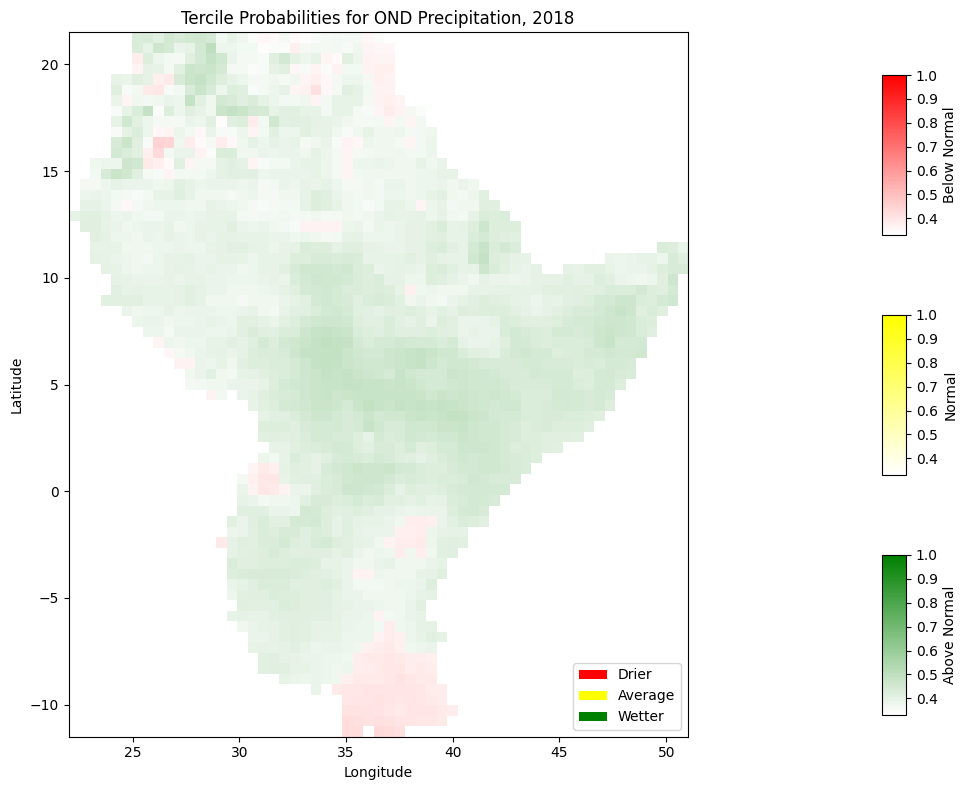

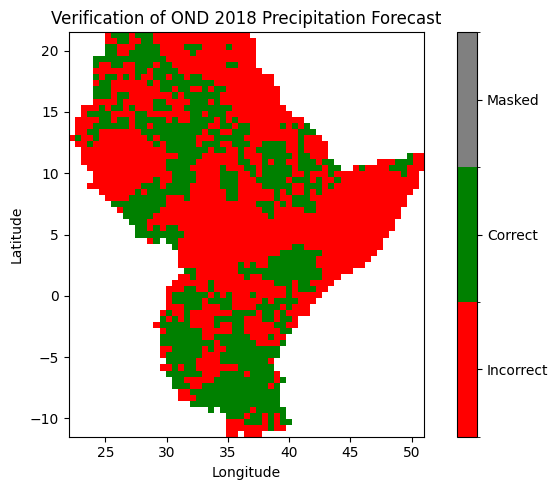

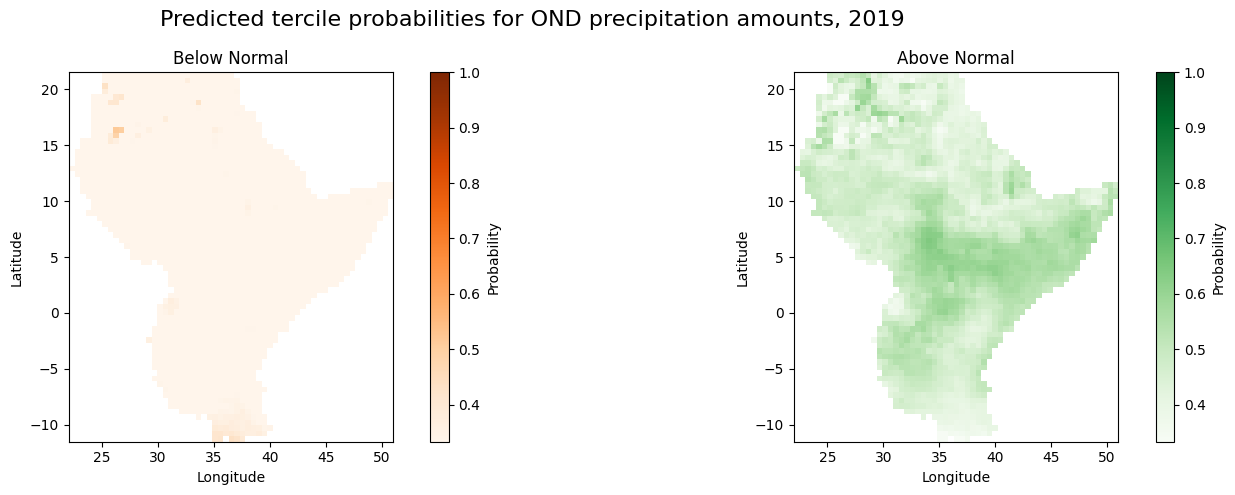

0.2516474092338845
0.2666113930294467
0.26603722175660893
0.2615390839306846
0.2653983155781654
0.25802210472973
0.26135420428492695
0.2604795259201306
0.26000590966057346
0.2584203029817337
0.2600072726658189
0.2632685512056978
0.26000755129945874
0.27847908657407494
0.27414327622862167
0.2643655715291542
0.26865742156646233
0.26594508632373937
0.2814902010930582
0.28012003570135036
0.2794636609127006
0.26165768340058515
0.27291376609089957
0.2836521351026662
0.2896783598795951
0.2779580954740475
0.2686948000840951
0.26699981072486556
0.2731779731458117
0.2577683892110638
0.2714728184992483
0.27658643047662157
0.2825048047873797
0.2899858781316489
0.288657884348101
0.28996693831892595
0.28451998408098467
0.2877713779175761
0.2817315191325702
0.2844558755967713
0.3009183310293889
0.30048035731105993
0.28870165653465985
0.2830368544673937
0.28238649600757293
0.29181001571626375
0.296184657764091
0.3100242721341926
0.30165939877674974
0.3007058738526529
0.29482205423611796
0.301243166846

/nr/samba/user/ahellevik/CONFER-WP3/src/confer_wp3/plotting.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


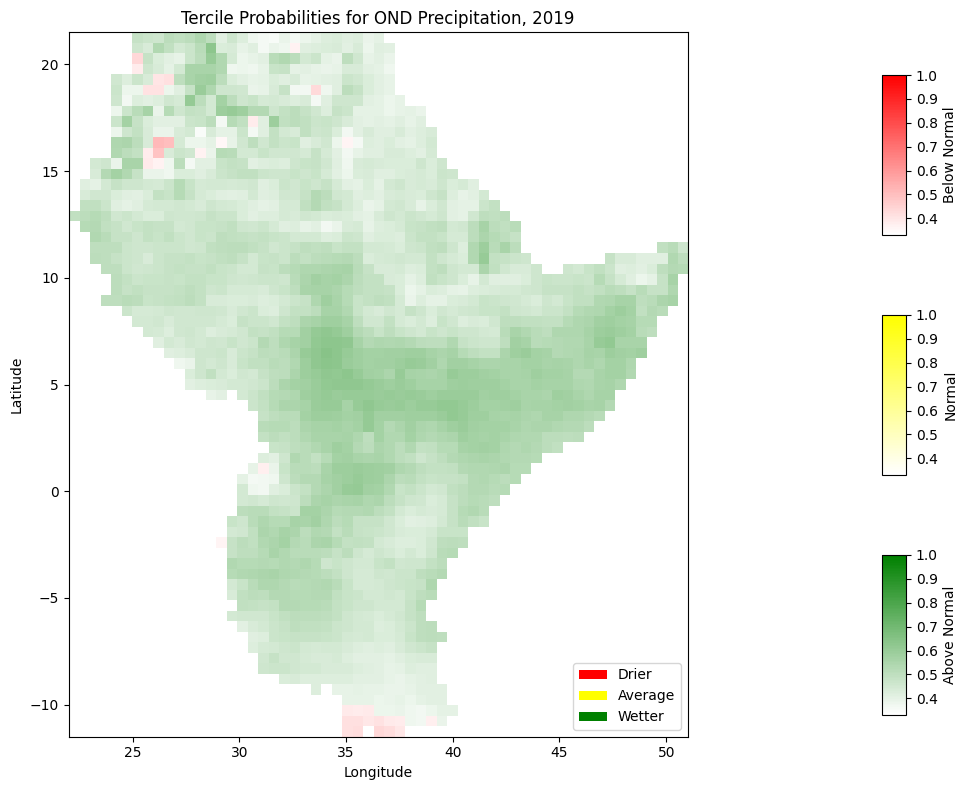

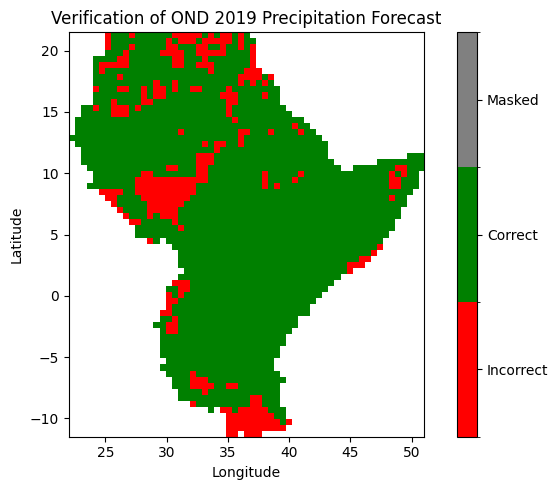

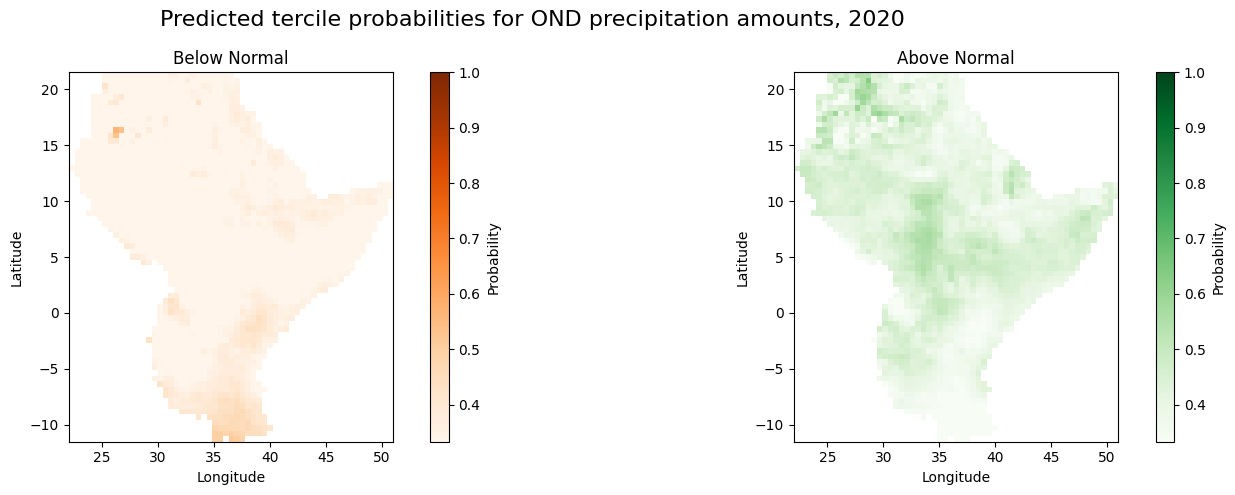

0.24323691301868677
0.26117729353817554
0.26054969846330855
0.2609933533466775
0.26598136598585
0.2589399568523273
0.26215397864453527
0.2638365348894761
0.2673868272917419
0.2653975110819785
0.2647017127581651
0.2697862589944451
0.26688179316444693
0.28348840410753484
0.2809175150863841
0.27445808982512543
0.27724313076093654
0.27445457520619865
0.2793102039544517
0.2871052094583396
0.2852437853681561
0.26716952121510285
0.27675622237302244
0.28388874912246176
0.2895630007741665
0.27861238782644715
0.2798039458600754
0.2842201354652204
0.2893268205266273
0.27388517875428375
0.2794064802968814
0.2817316679472628
0.28519798130145113
0.2949112083579265
0.29244575815689644
0.2908331883305688
0.287857837651752
0.2920857695754808
0.28630484144247526
0.2877823993456603
0.3036263338190732
0.3044396804894346
0.2945597510284881
0.2887385268165956
0.28758961624385293
0.2961617896513997
0.30757239319410723
0.31370877750275683
0.301132405560148
0.3039976916002719
0.2970125618684092
0.3028401864654

/nr/samba/user/ahellevik/CONFER-WP3/src/confer_wp3/plotting.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


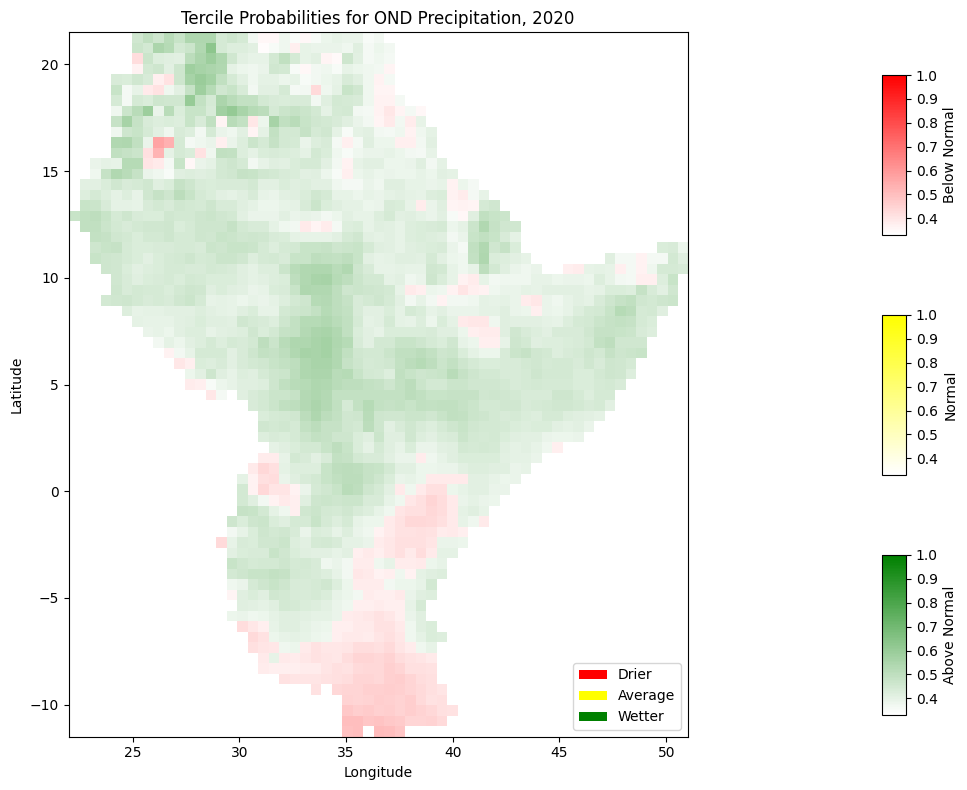

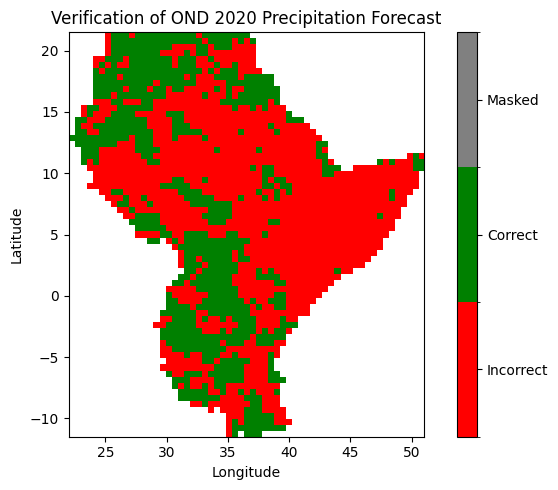

In [22]:
# Verifying tercile forecast predictions for some recent years
for year_fcst in range(2015, 2021):
    # Get tercile probability forecasts
    prob_bn, prob_an = calculate_tercile_probability_forecasts(era5_indices, anomalies_normal, eofs_reshaped, df_coefficients, df_fl_pred_cov, var_fracs, feature_names, year, period_clm, n_eofs, year_fcst, month_init)

    # Plot the probabilities
    plot_fields_simple(fields=[prob_bn, prob_an],
                titles=['Below Normal', 'Above Normal'],
                cmap=['Oranges', 'Greens'],
                unit='Probability',
                lat = lat,
                lon = lon,
                season=season,
                year=year_fcst)
    
    # Plot tercile forecast in one plot
    plot_combined_terciles(prob_bn, prob_an, lat, lon, season, year_fcst)
    
    # Plot the verification
    validate_forecast(prob_bn, prob_an, prec_data, period_clm, period_train, year, lat, lon, season, year_fcst)
